##### Import libraries and prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
img_rows = img_cols = 28
num_classes = 11
pathToData = '/content/gdrive/MyDrive/sets/'
show_img = True
train_model = True
save_model = True
load_model = True
show_model = True
fn_w = pathToData + 'model.wei' # Файл с весами НС

In [ ]:
batch_size = 128 # Размер обучающего (проверочного) пакета
n_epochs = 20 # Число эпох обучения
criterion = nn.CrossEntropyLoss() # Функция потерь

In [ ]:
import string
letters = list(string.ascii_uppercase)

In [ ]:
def load_bin_data(pathToData, img_rows, img_cols, num_classes, show_img):
    print('Загрузка данных из двоичных файлов')
    with open(pathToData + 'imagesTrain.bin', 'rb') as read_binary:
        x_trn = np.fromfile(read_binary, dtype = np.uint8)
    with open(pathToData + 'labelsTrain.bin', 'rb') as read_binary:
        y_trn = np.fromfile(read_binary, dtype = np.uint8)
    with open(pathToData + 'imagesTest.bin', 'rb') as read_binary:
        x_tst = np.fromfile(read_binary, dtype = np.uint8)
    with open(pathToData + 'labelsTest.bin', 'rb') as read_binary:
        y_tst = np.fromfile(read_binary, dtype = np.uint8)
    if num_classes == 10:
        x_trn = x_trn.reshape(-1, 1, img_rows, img_cols)
        x_tst = x_tst.reshape(-1, 1, img_rows, img_cols)
    else:
        x_trn = x_trn.reshape(-1, 1, img_rows, img_cols).transpose(0, 1, 3, 2)
        x_tst = x_tst.reshape(-1, 1, img_rows, img_cols).transpose(0, 1, 3, 2)
        y_trn -= 1
        y_tst -= 1
    if show_img:
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            img = x_trn[i].reshape(img_rows, img_cols)
            plt.imshow(img, cmap = plt.get_cmap('gray'))
            if num_classes == 10:
                plt.title(y_trn[i])
            else:
                plt.title(letters[y_trn[i]])
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.5)
        plt.show()
    print(x_trn.shape)
    x_trn = np.array(x_trn, dtype = 'float32') / 255
    x_tst = np.array(x_tst, dtype = 'float32') / 255
    return x_trn, y_trn, x_tst, y_tst

Загрузка данных из двоичных файлов


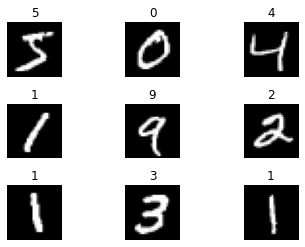

(60000, 1, 28, 28)


In [ ]:
mnist_trn, mnist_ltrn, mnist_tst, mnist_ltst = load_bin_data(pathToData + 'mnist/', img_rows, img_cols,
                                           10, show_img)

Загрузка данных из двоичных файлов


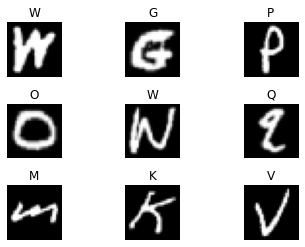

(124800, 1, 28, 28)


In [ ]:
emnist_trn, emnist_ltrn, emnist_tst, emnist_ltst = load_bin_data(pathToData + 'emnist/', img_rows, img_cols,
                                           26, show_img)

1. Пополнить MNIST 11-м классом "не цифры", поместив в него случайно выбранные буквы EMNIST.
   11-й класс формируется из представителей всех классов EMNIST.
   В обучающую порцию данных 11-го класса добавляются по 231 примеру из первых 20-и классов EMNIST
   и по 230 из последующих (231 * 20 + 230 * 6 = 6000).
   Аналогично создается и проверочная порция данных 11-го класса MNIST.
   В проверочную порцию данных 11-го класса добавляются по 38 примеров из первых 20-и классов EMNIST
   и по 40 из последующих (38 * 20 + 40 * 6 = 1000).

TRAIN

In [ ]:
ind = []
for i in range(26):
    ind.append(np.where(emnist_ltrn == i)[0])

In [ ]:
len(ind)

26

In [ ]:
ind[0]

array([    29,     32,     35, ..., 124776, 124781, 124784])

In [ ]:
for i in range(20):
    ind[i] = ind[i][:231]
for i in range(20, 26):
    ind[i] = ind[i][:230]

In [ ]:
emnist_train = []
for i in range(26):
    emnist_train.append(emnist_trn[ind[i]])

In [ ]:
emnist_train[0].shape

(231, 1, 28, 28)

In [ ]:
emnist_train[20].shape

(230, 1, 28, 28)

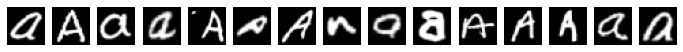

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.axis('Off')
    plt.imshow(emnist_train[0][i].reshape(img_rows, img_cols), cmap='gray')
plt.show()

In [ ]:
x_train = np.copy(mnist_trn)

In [ ]:
x_train.shape

(60000, 1, 28, 28)

In [ ]:
for i in range(26):
    x_train = np.append(x_train, emnist_train[i], axis = 0)

In [ ]:
x_train.shape

(66000, 1, 28, 28)

In [ ]:
y_train = np.copy(mnist_ltrn)

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_train = np.append(y_train, [10] * 6000, axis = 0)

In [ ]:
y_train.shape

(66000,)

In [ ]:
ind = np.random.permutation(x_train.shape[0])

In [ ]:
x_train = x_train[ind]
y_train = y_train[ind]

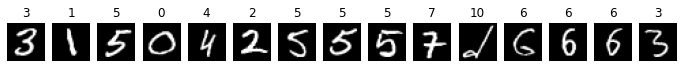

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.axis('Off')
    plt.title(y_train[i])
    plt.imshow(x_train[i].reshape(img_rows, img_cols), cmap='gray')
plt.show()

TEST

In [ ]:
ind = []
for i in range(26):
    ind.append(np.where(emnist_ltst == i)[0])

In [ ]:
for i in range(20):
    ind[i] = ind[i][:38]
for i in range(20, 26):
    ind[i] = ind[i][:40]

In [ ]:
emnist_test = []
for i in range(26):
    emnist_test.append(emnist_tst[ind[i]])

In [ ]:
emnist_test[0].shape

(38, 1, 28, 28)

In [ ]:
emnist_test[20].shape

(40, 1, 28, 28)

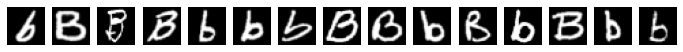

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.axis('Off')
    plt.imshow(emnist_test[1][i].reshape(img_rows, img_cols), cmap='gray')
plt.show()

In [ ]:
x_test = np.copy(mnist_tst)

In [ ]:
x_test.shape

(10000, 1, 28, 28)

In [ ]:
for i in range(26):
    x_test = np.append(x_test, emnist_test[i], axis = 0)

In [ ]:
x_test.shape

(11000, 1, 28, 28)

In [ ]:
y_test = np.copy(mnist_ltst)

In [ ]:
y_test.shape

(10000,)

In [ ]:
y_test = np.append(y_test, [10] * 1000, axis = 0)

In [ ]:
y_test.shape

(11000,)

In [ ]:
ind = np.random.permutation(x_test.shape[0])

In [ ]:
x_test = x_test[ind]
y_test = y_test[ind]

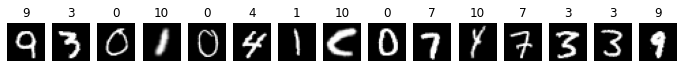

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.axis('Off')
    plt.title(y_test[i + 1000])
    plt.imshow(x_test[i + 1000].reshape(img_rows, img_cols), cmap='gray')
plt.show()

##### Shapes

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(66000, 1, 28, 28)
(11000, 1, 28, 28)
(66000,)
(11000,)


2. Используя PyTorch, создать и обучить модель нейронной сети для классификации примеров сформированного в п. 1 набора данных.
   Максимально приблизить точность классификации к 99,6%.
3. Обученную модель сохранить в файл.
4. При обучении, кроме потерь, выводить точность.

66000


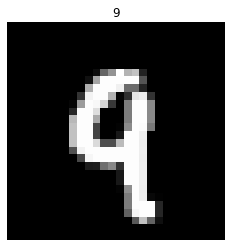

In [ ]:
trn_data = [[x, int(y)] for x, y in zip(x_train, y_train)]
trn_loader = DataLoader(trn_data, batch_size = batch_size, shuffle = True)
in_trn = len(trn_loader.sampler) # 66000
print(in_trn)
if show_img:
    trn_features, trn_labels = next(iter(trn_loader))
    img = trn_features[0].squeeze()
    ind = int(trn_labels[0])
    plt.imshow(img, cmap = 'gray')
    plt.title(ind)
    plt.axis('off')
    plt.show()

In [ ]:
print(trn_loader)

In [ ]:
tst_data = torch.tensor(x_test)
tst_target = torch.tensor(np.array(y_test, dtype = np.int64))
in_tst = len(tst_data) # 11000
print(in_tst)

11000


In [ ]:
arr_loss = [0] * n_epochs
arr_acc = [0] * n_epochs
arr_val_loss = [0] * n_epochs
arr_val_acc = [0] * n_epochs

In [ ]:
def train(epoch, tst_size):
    model.train() # Режим обучения
    for batch_no, (data, target) in enumerate(trn_loader): 
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # Обнуляем градиенты 
        output = model(data) # forward 
        loss = criterion(output, target) # <class 'torch.Tensor'>
        _, pred = torch.max(output, 1)
        loss.backward() # Подготовка потерь для обратного шага
        optimizer.step() # Обратное распространение ошибки, обновляем веса модели
        arr_loss[epoch] += loss.item() * data.size(0)
        arr_acc[epoch] += pred.eq(target).cpu().sum()
    arr_loss[epoch] = arr_loss[epoch] / in_trn
    arr_acc[epoch] = arr_acc[epoch] / in_trn
    model.eval() # Режим оценки
    tst_dt, tst_trgt = tst_data[:tst_size].to(device), tst_target[:tst_size].to(device)
    output = model(tst_dt)
    arr_val_loss[epoch] = criterion(output, tst_trgt)
    _, pred = torch.max(output, 1)
    arr_val_acc[epoch] = pred.eq(tst_trgt).cpu().sum() / tst_size
    torch.cuda.empty_cache()
    print('Эпоха: {} loss: {:.6f} acc: {:.4f} val_loss: {:.6f} val_acc: {:.4f}'.format(
        epoch + 1, arr_loss[epoch], arr_acc[epoch], arr_val_loss[epoch], arr_val_acc[epoch]))

In [ ]:
class Net(nn.Module):
      def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3)
        self.pool2d1 = nn.MaxPool2d(2)
        self.pool2d2 = nn.MaxPool2d(2)
        self.pool2d3 = nn.MaxPool2d(2)
        self.b_norm1 = nn.BatchNorm2d(64)
        self.b_norm2 = nn.BatchNorm2d(128)
        self.b_norm3 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 11)
      def forward(self, x):
        input = F.relu(self.conv1(x))
        x = F.relu(self.conv2(input))
        x = self.pool2d1(x)
        x = self.b_norm1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2d2(x)
        x = self.b_norm2(x)
        x = F.relu(self.conv5(x))
        x = self.pool2d3(x)
        x = x.view(-1, 256)
        x = self.b_norm3(x)
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return F.log_softmax(output, dim = -1)

In [ ]:
model = Net().to(device) # Формируем модель НС
if show_model: 
    print(model)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool2d1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2d2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2d3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=11, bias=True)
)


In [ ]:
if train_model:
    print('Число эпох', n_epochs)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    print('Обучение')
    for ep in range(n_epochs):
        train(ep, 512)

Число эпох 20
Обучение
Эпоха: 1 loss: 0.172161 acc: 0.9512 val_loss: 0.066092 val_acc: 0.9785
Эпоха: 2 loss: 0.060592 acc: 0.9832 val_loss: 0.213382 val_acc: 0.9336
Эпоха: 3 loss: 0.045192 acc: 0.9872 val_loss: 0.068769 val_acc: 0.9883
Эпоха: 4 loss: 0.035363 acc: 0.9898 val_loss: 0.105414 val_acc: 0.9746
Эпоха: 5 loss: 0.036963 acc: 0.9897 val_loss: 0.032413 val_acc: 0.9883
Эпоха: 6 loss: 0.030561 acc: 0.9917 val_loss: 0.124034 val_acc: 0.9805
Эпоха: 7 loss: 0.029716 acc: 0.9917 val_loss: 0.044146 val_acc: 0.9902
Эпоха: 8 loss: 0.028462 acc: 0.9924 val_loss: 0.128120 val_acc: 0.9688
Эпоха: 9 loss: 0.026496 acc: 0.9930 val_loss: 0.142341 val_acc: 0.9844
Эпоха: 10 loss: 0.026949 acc: 0.9929 val_loss: 0.075120 val_acc: 0.9824
Эпоха: 11 loss: 0.019992 acc: 0.9949 val_loss: 0.027345 val_acc: 0.9941
Эпоха: 12 loss: 0.025070 acc: 0.9936 val_loss: 0.041374 val_acc: 0.9883
Эпоха: 13 loss: 0.022252 acc: 0.9942 val_loss: 0.093022 val_acc: 0.9922
Эпоха: 14 loss: 0.019349 acc: 0.9951 val_loss: 0.0

In [ ]:
if save_model:
        print('Сохранение весов модели')
        torch.save(model.state_dict(), fn_w)

Сохранение весов модели


5. Построить графики обучения (по аналогии с ЛР6).

In [ ]:
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'acc', 'val_acc'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.0
    plt.plot(loss_acc, color='r', label=lb, linestyle='--')
    plt.plot(val_loss_acc, color='g', label=lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    # plt.ylim([0.95 * yMin, yMax])
    plt.legend()

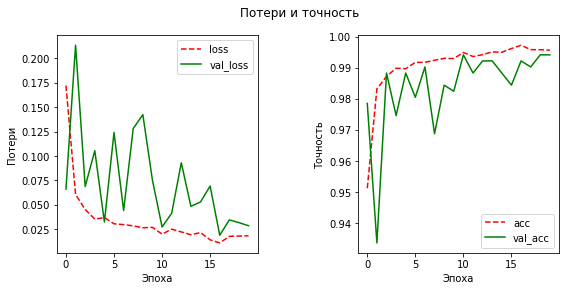

In [ ]:
plt.figure(figsize=(9, 4))
plt.subplots_adjust(wspace=0.5)
one_plot(1, 'Потери', arr_loss, arr_val_loss)
one_plot(2, 'Точность', arr_acc, arr_val_acc)
plt.suptitle('Потери и точность')
plt.show()

6. В режиме проверки (прогнозирования) загружать модель из файла.
7. Вывести точность классификации примеров проверочного множества по классам.

In [ ]:
if load_model:
    print('Загрузка весов из файла', fn_w)
    model.load_state_dict(torch.load(fn_w, map_location = torch.device(device)))

Загрузка весов из файла /content/gdrive/MyDrive/sets/model.wei


In [ ]:
def test(tst_size):
    print('Проверка') 
    # Число верно классифицированных цифр в каждом классе
    cls_correct = [0]*num_classes 
    cls_total = [0]*num_classes # Число цифр в каждом классе
    model.eval() # Режим оценки 
    output = model(tst_data[:tst_size].to(device))
    # Потери на проверочном множестве (ПМ)
    tst_loss = criterion(output, tst_target[:tst_size].to(device))
    _, pred = torch.max(output, 1)
    for label, c in zip(tst_target[:tst_size].to(device), pred == tst_target[:tst_size].to(device)):
        cls_correct[label] += c
        cls_total[label] += 1
    print('Потери: {:.6f}'.format(tst_loss))
    print('Точность: {:.4f}'.format(sum(cls_correct) / sum(cls_total)))
    print('Точность по классам:')
    for cls, cc_ct in enumerate(zip(cls_correct, cls_total)):
        print('{} - {:.4f}'.format(cls, cc_ct[0] / cc_ct[1]))

In [ ]:
test(2048)

Проверка
Потери: 0.058914
Точность: 0.9907
Точность по классам:
0 - 0.9835
1 - 0.9952
2 - 1.0000
3 - 1.0000
4 - 0.9744
5 - 0.9870
6 - 0.9747
7 - 0.9950
8 - 0.9902
9 - 0.9937
10 - 1.0000


In [ ]:
def show_res():
    print('Прогноз для 20 случайных примеров проверочного множества')
    N = 20 
    arr_idx = np.random.randint(0, len(tst_target), N)
    images = tst_data[arr_idx]
    labels = tst_target[arr_idx]
    output = model(images)
    _, pred = torch.max(output, 1)
    images = images.numpy()
    fig = plt.figure(figsize = (12, 3))
    for i in range(N): 
        ax = fig.add_subplot(2, int(N / 2), i + 1, xticks = [], yticks = [])
        img = images[i] # (1, 28, 28)
        img = np.squeeze(img) # или: img = img.reshape(img_rows, img_cols)
        ax.imshow(img, cmap = 'gray')
        ttl = str(int(pred[i].item())) + ' (' + str(labels[i].item()) + ')'
        clr = 'green' if pred[i] == labels[i] else 'red'
        ax.set_title(ttl, color = clr)
    plt.show()